# QAQC Plot for LARGEEE

Note: Change `table_name` in "Load Data" Section before running notebook (they are marked with TODO)

## Import modules

In [1]:
import pandas as pd
from pathlib import Path

# from buildstock_query import BuildStockQuery
import qaqc_helper

## Constants & Funcs

In [2]:
output_dir = Path(".").resolve() / "data" / "output"
output_dir.mkdir(parents=True, exist_ok=True)


## Download data

In [3]:
### run CLI to see what's available
!aws s3 ls largeee/test_runs/

                           PRE baseline_20230525/
                           PRE cateory_2_20230525/
                           PRE cateory_3_20230525/
                           PRE cateory_4_20230525/
                           PRE medium_run_baseline_20230622/
                           PRE medium_run_category_1_20230622/
                           PRE small_run_baseline_20230613/
                           PRE small_run_baseline_20230627/
                           PRE small_run_category_1_20230616/
                           PRE small_run_category_2_20230616/
                           PRE small_run_category_2_20230622/
                           PRE small_run_category_2_20230629/
                           PRE small_run_category_2_20230630/
                           PRE small_run_category_3_20230615/
                           PRE small_run_category_3_20230629/
                           PRE small_run_category_4_20230622/
                           PRE small_run_category_4_20230

In [4]:
table_name = "small_run_baseline_20230810_100" ## <---- TODO: specify table for download
s3_prefix = f"test_runs/{table_name}/" 

data_dir = qaqc_helper.s3_download.get_localdir_for_run(s3_prefix)
qaqc_helper.s3_download.download_s3_files(s3_prefix, destination=data_dir)

Data directory: C:\Users\pwhite2\Documents\GitHub\fact_sheets\resstock\docs\validation\data\small_run_baseline_20230810_100
C:\Users\pwhite2\Documents\GitHub\fact_sheets\resstock\docs\validation\data\small_run_baseline_20230810_100 files exist, no downloading


### Load

In [5]:
N_UNITS = 136569411
table_name = "small_run_category_2_20230811" # <--- folder containing upgrades only 
data_dir = qaqc_helper.s3_download.get_localdir_for_run(table_name)
baseline_data_dir = Path(".").resolve() / "data" / "small_run_baseline_20230810_100" # <--- TODO: make sure baseline is correct
print(f"baseline_data_dir: {baseline_data_dir}")

Data directory: C:\Users\pwhite2\Documents\GitHub\fact_sheets\resstock\docs\validation\data\small_run_category_2_20230811
baseline_data_dir: C:\Users\pwhite2\Documents\GitHub\fact_sheets\resstock\docs\validation\data\small_run_baseline_20230810_100


### Flag failure and invalid samples
Invalid means upgrades does not apply

In [6]:
dfb, DFU = qaqc_helper.load_process.load_baseline_and_upgrades(data_dir, baseline_data_dir=baseline_data_dir, success_only=True)


        Returned output is: 
            first output: baseline dataframe
            second output: dictionary of upgrade packages, with key = upgrade_name and value = upgrade dataframe
        
Baseline: completed_status
Success    100
Name: building_id, dtype: int64
Upgrade Thin Triple Windows: completed_status
Success    100
Name: building_id, dtype: int64
Upgrade EnergyStar Windows: completed_status
Success    100
Name: building_id, dtype: int64
Upgrade Light Touch Envelope: completed_status
Invalid     6
Success    94
Name: building_id, dtype: int64
Upgrade Intermediate Envelope: completed_status
Invalid     1
Success    99
Name: building_id, dtype: int64
Upgrade Advanced Enclosure with ERVs for all: completed_status
Success    100
Name: building_id, dtype: int64
Upgrade Advanced Enclosure with mix of ERVs and exhaust-only ventilation: completed_status
Success    100
Name: building_id, dtype: int64


In [8]:
### check what's available based on key word
key_word = "report_simulation_output.fuel_use" # <---
[col for col in dfb.columns if key_word in col]

['report_simulation_output.fuel_use_coal_total_m_btu',
 'report_simulation_output.fuel_use_electricity_net_m_btu',
 'report_simulation_output.fuel_use_electricity_total_m_btu',
 'report_simulation_output.fuel_use_fuel_oil_total_m_btu',
 'report_simulation_output.fuel_use_natural_gas_total_m_btu',
 'report_simulation_output.fuel_use_propane_total_m_btu',
 'report_simulation_output.fuel_use_wood_cord_total_m_btu',
 'report_simulation_output.fuel_use_wood_pellets_total_m_btu']

### Check fixed costs are being removed when a fuel is no longer being used

In [9]:
enduse_list = ['coal', 'electricity','fuel_oil','natural_gas','propane','wood_cord','wood_pellets']
for enduse in enduse_list:
    Error = 0
    for row in range(1,len(dfb)):
        if dfb.iloc[row][f'report_simulation_output.fuel_use_{enduse}_total_m_btu'] == 0 and dfb.iloc[row][f'report_utility_bills.utility_rates_fixed_variable_{enduse}_fixed_usd'] !=0:
            Error += 1
    if Error > 0:
        print("Error: " + enduse)
    if Error == 0:
        print("Fixed costs are being removed when a fuel is no longer being used: "+enduse)

Fixed costs are being removed when a fuel is no longer being used: coal
Fixed costs are being removed when a fuel is no longer being used: electricity
Fixed costs are being removed when a fuel is no longer being used: fuel_oil
Fixed costs are being removed when a fuel is no longer being used: natural_gas
Fixed costs are being removed when a fuel is no longer being used: propane
Fixed costs are being removed when a fuel is no longer being used: wood_cord
Fixed costs are being removed when a fuel is no longer being used: wood_pellets


### Results

#### 1. Energy savings

check fuel type with consumption

In [10]:
fuel_list = ['coal', 'electricity','fuel_oil','natural_gas','propane','wood_cord','wood_pellets']
fuel_end_use_with_changes = []
for fuel in fuel_list:
    if dfb[f'report_simulation_output.fuel_use_{fuel}_total_m_btu'].any() == True:
        print(f'report_simulation_output.fuel_use_{fuel}_total_m_btu')

report_simulation_output.fuel_use_electricity_total_m_btu
report_simulation_output.fuel_use_fuel_oil_total_m_btu
report_simulation_output.fuel_use_natural_gas_total_m_btu


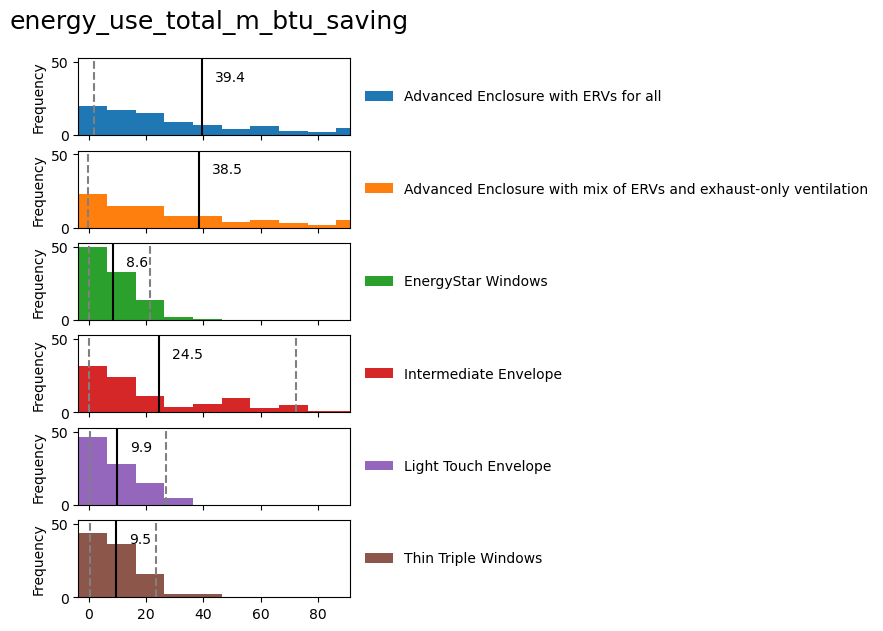

In [11]:
metric = "report_simulation_output.energy_use_total_m_btu"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"]
nbins = 20

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

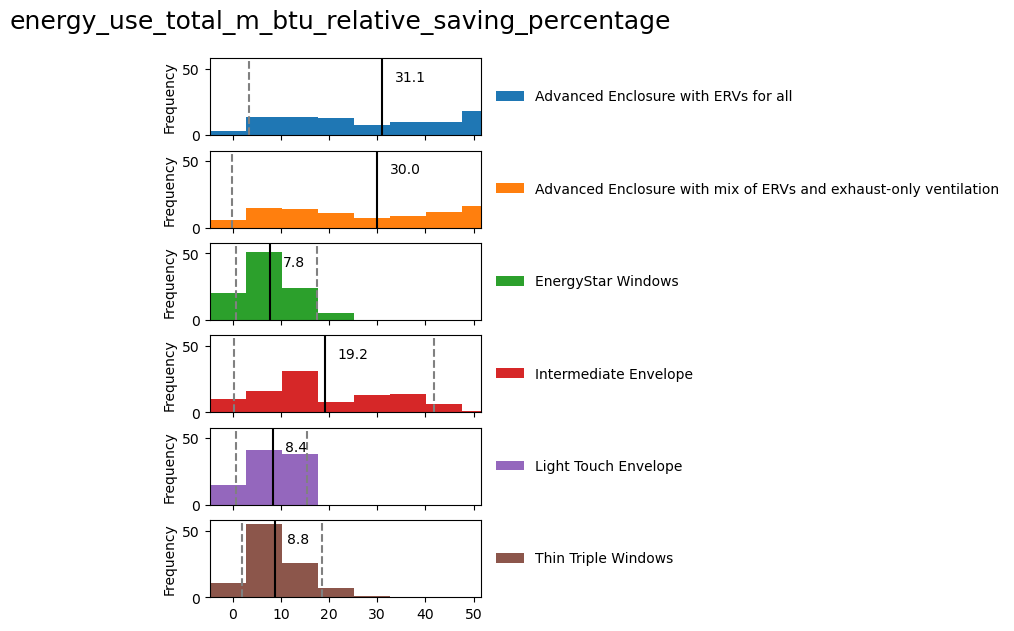

In [12]:
metric = "report_simulation_output.energy_use_total_m_btu"
output_type = "relative_saving_percentage" # negative saving means net increase

hc = ["upgrade"]
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_relative_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

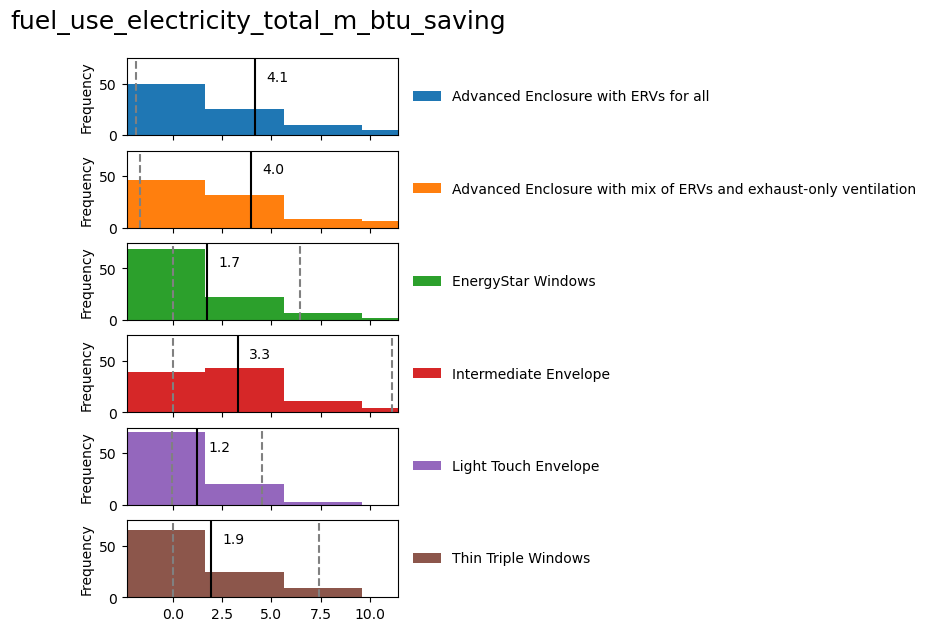

In [13]:
metric = "report_simulation_output.fuel_use_electricity_total_m_btu"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"]
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

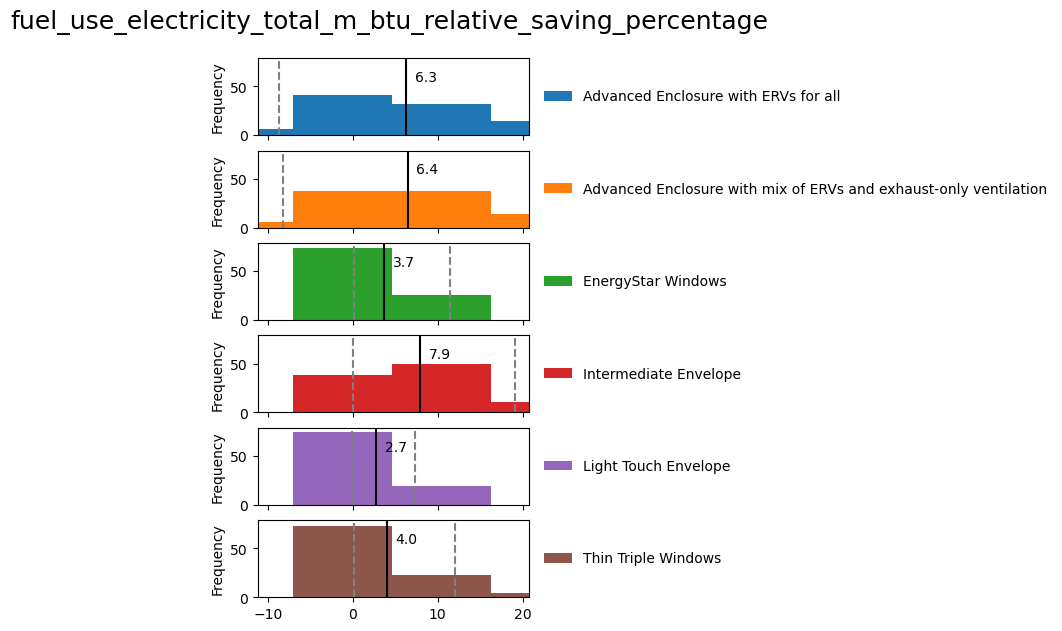

In [14]:
#check the data processing for electricity relatice saving
metric = "report_simulation_output.fuel_use_electricity_total_m_btu"
output_type = "relative_saving_percentage" # negative saving means net increase

hc = ["upgrade"]
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_relative_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

c:\Users\pwhite2\Documents\GitHub\fact_sheets\resstock\docs\validation\qaqc_helper\plot.py:224: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axes[0].set_xlim(xmin=xmin, xmax=xmax)


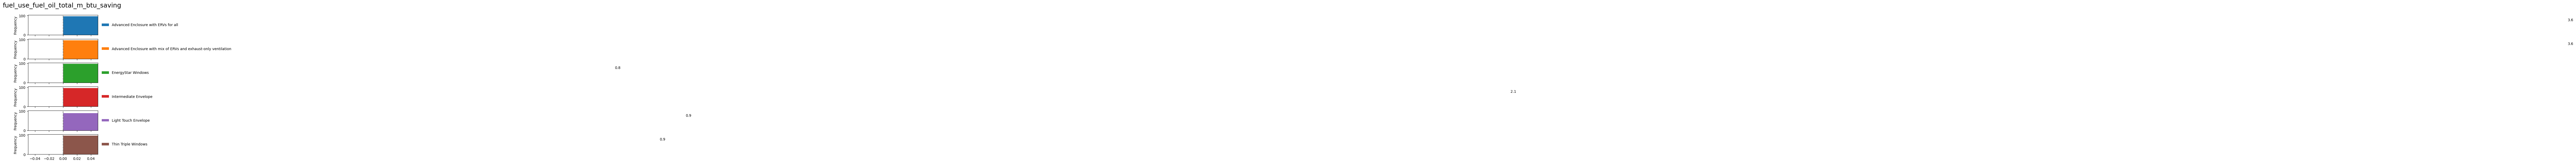

In [15]:
metric = "report_simulation_output.fuel_use_fuel_oil_total_m_btu"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"]
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

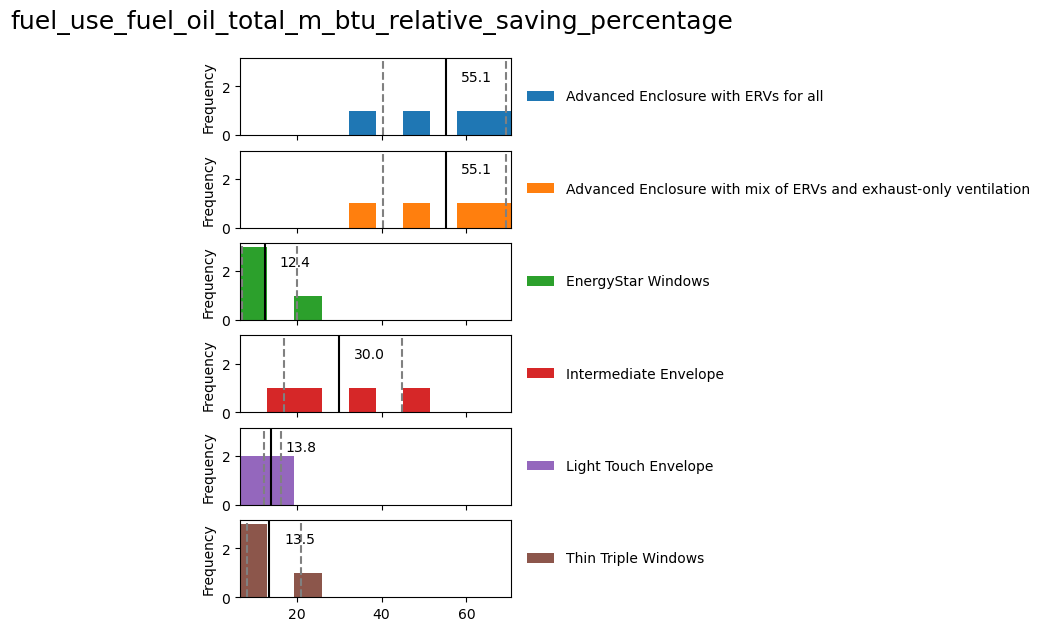

In [16]:
metric = "report_simulation_output.fuel_use_fuel_oil_total_m_btu"
output_type = "relative_saving_percentage" # negative saving means net increase

hc = ["upgrade"]
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_relative_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

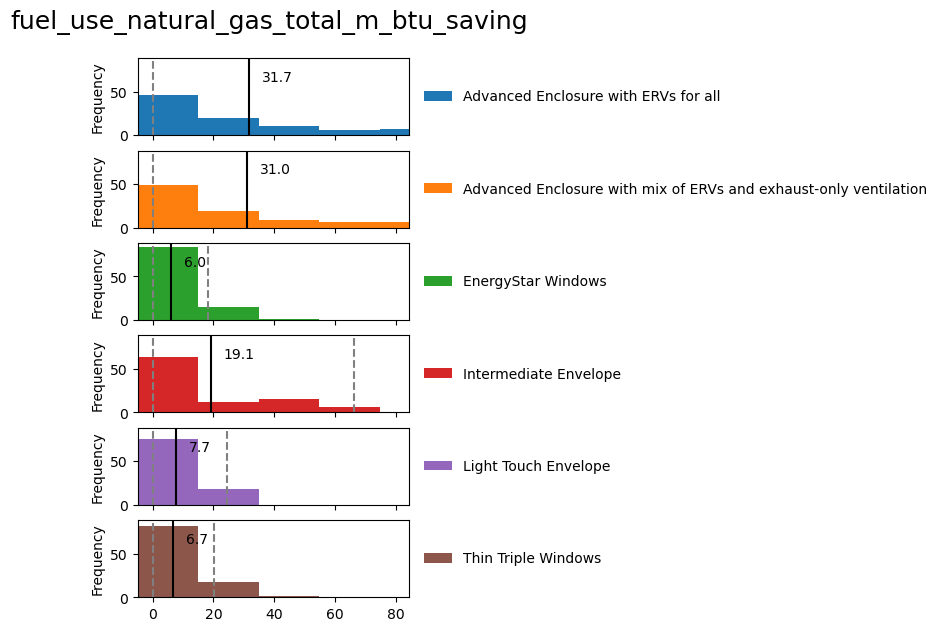

In [17]:
metric = "report_simulation_output.fuel_use_natural_gas_total_m_btu"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"]
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

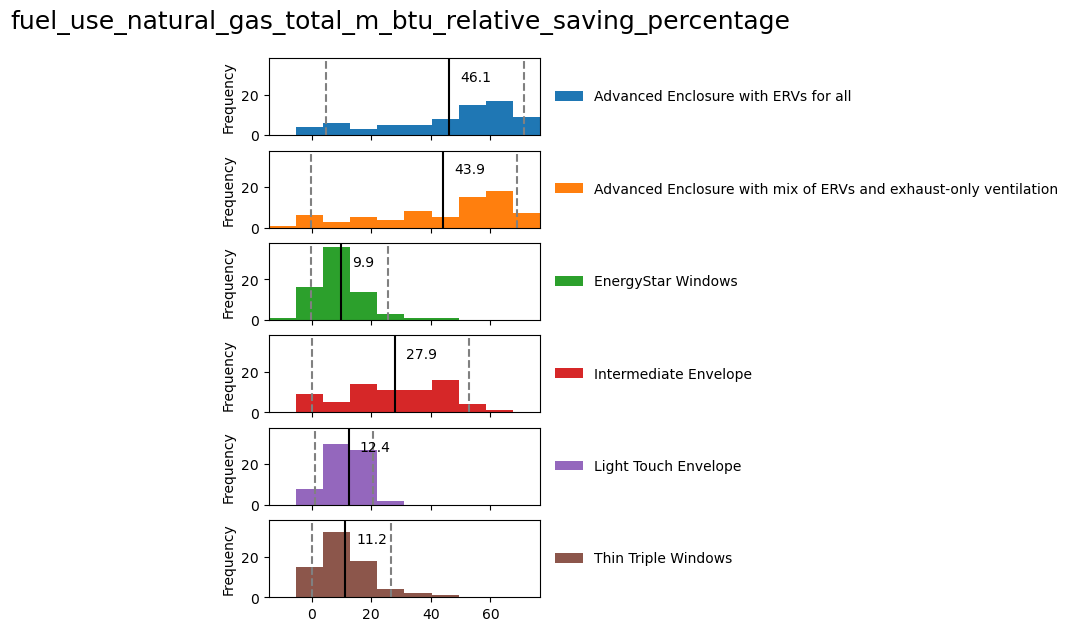

In [18]:
metric = "report_simulation_output.fuel_use_natural_gas_total_m_btu"
output_type = "relative_saving_percentage" # negative saving means net increase

hc = ["upgrade"]
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_relative_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

#### 2. Upgrade costs

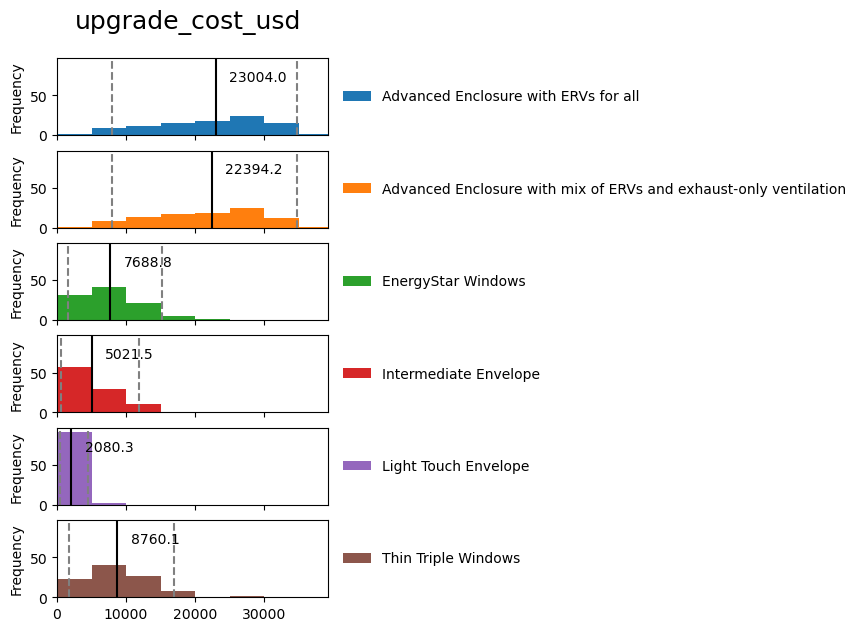

In [19]:
metric = "upgrade_costs.upgrade_cost_usd"
output_type = None
hc = ["upgrade"]
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric, hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

#### 3. Bill savings

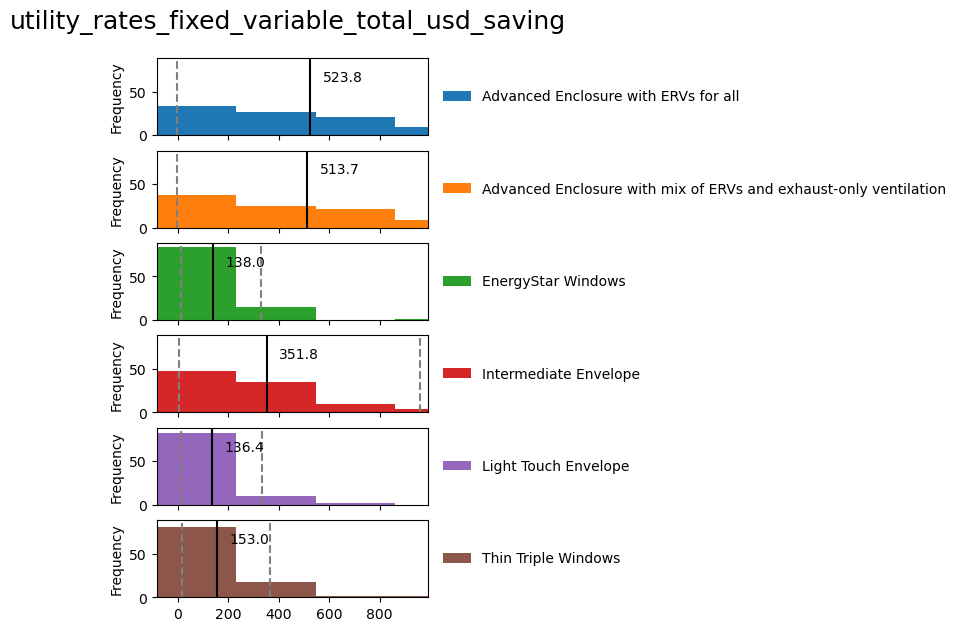

In [20]:
metric = "report_utility_bills.utility_rates_fixed_variable_total_usd"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"]
nbins = 10
#dark line is average value
dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

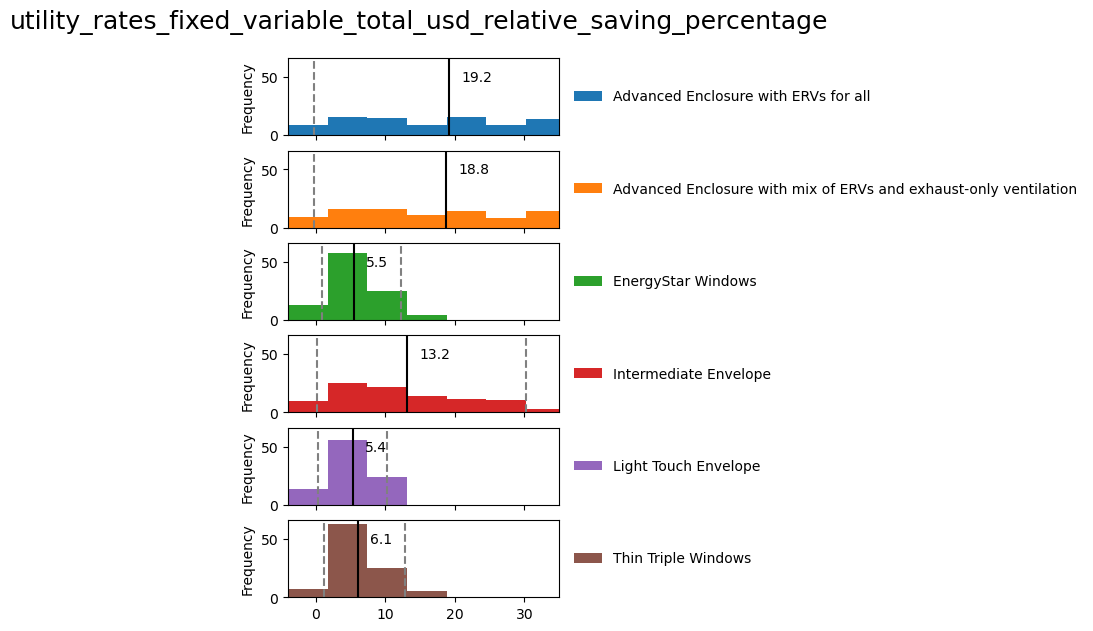

In [21]:
metric = "report_utility_bills.utility_rates_fixed_variable_total_usd"
output_type = "relative_saving_percentage" # negative saving means net increase

hc = ["upgrade"] # "lmi", "tenure"
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_relative_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

#### 4. Emission savings

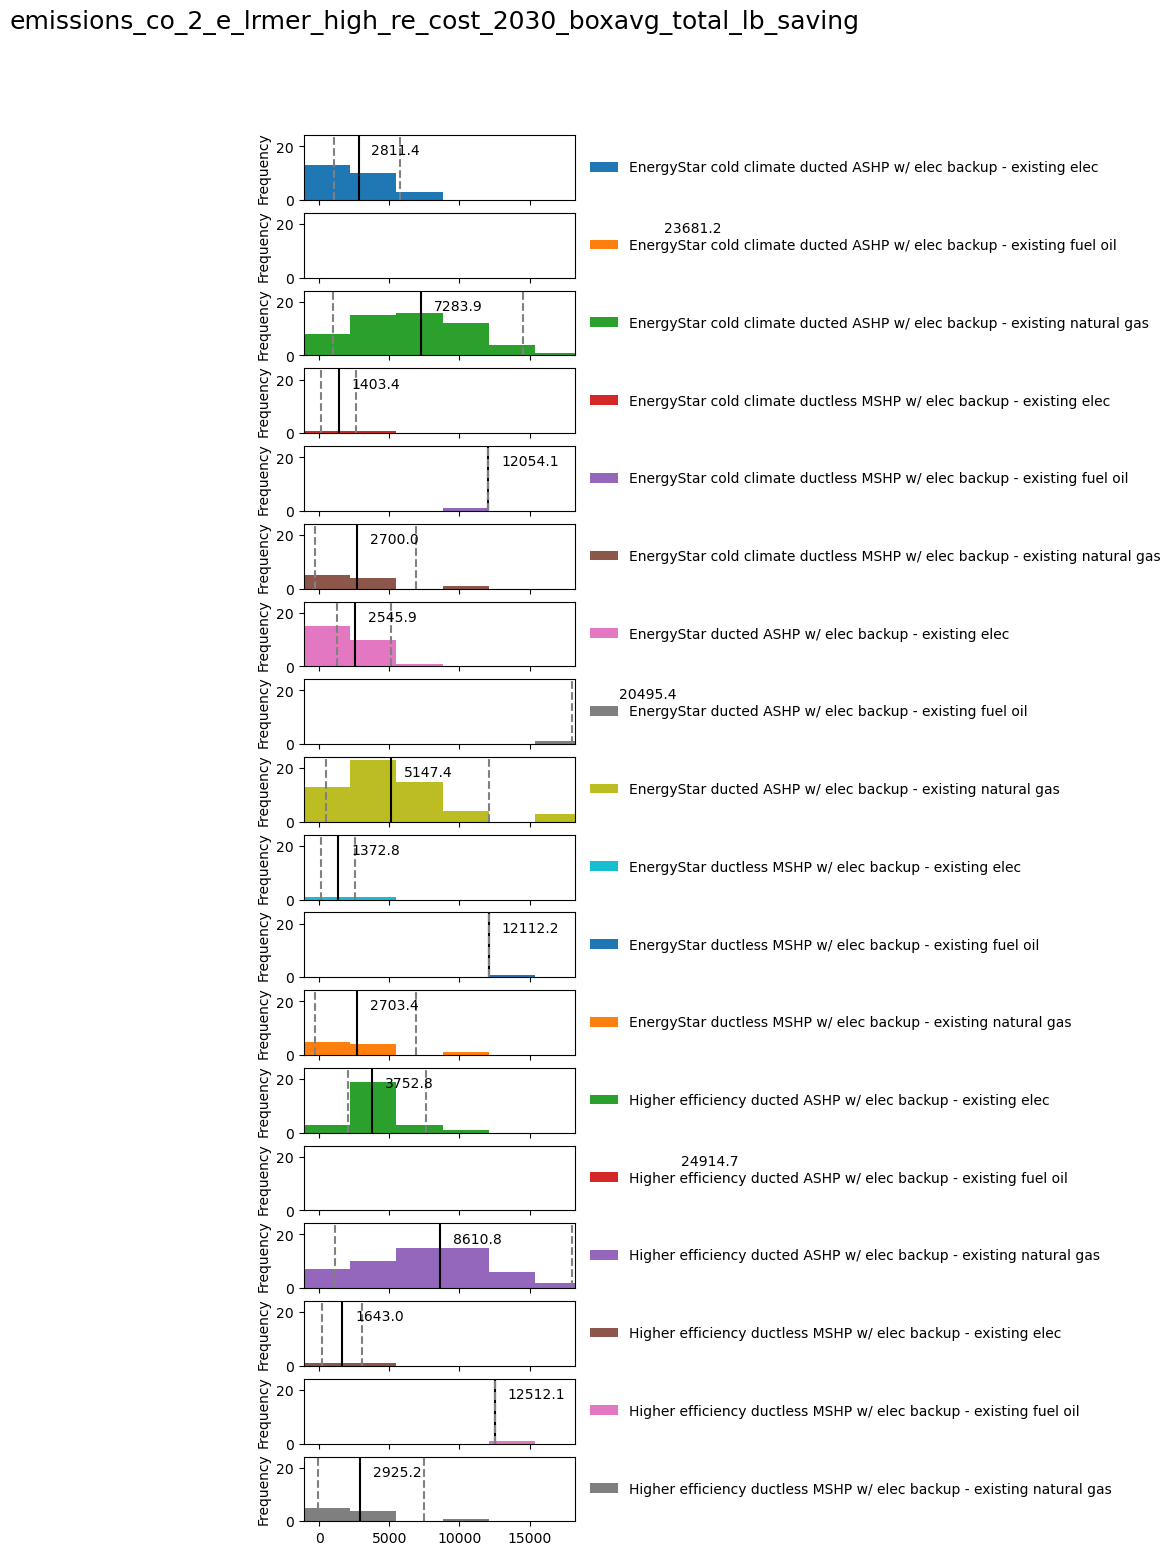

In [96]:
metric = "report_simulation_output.emissions_co_2_e_lrmer_high_re_cost_2030_boxavg_total_lb"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"] # "lmi", "tenure"
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

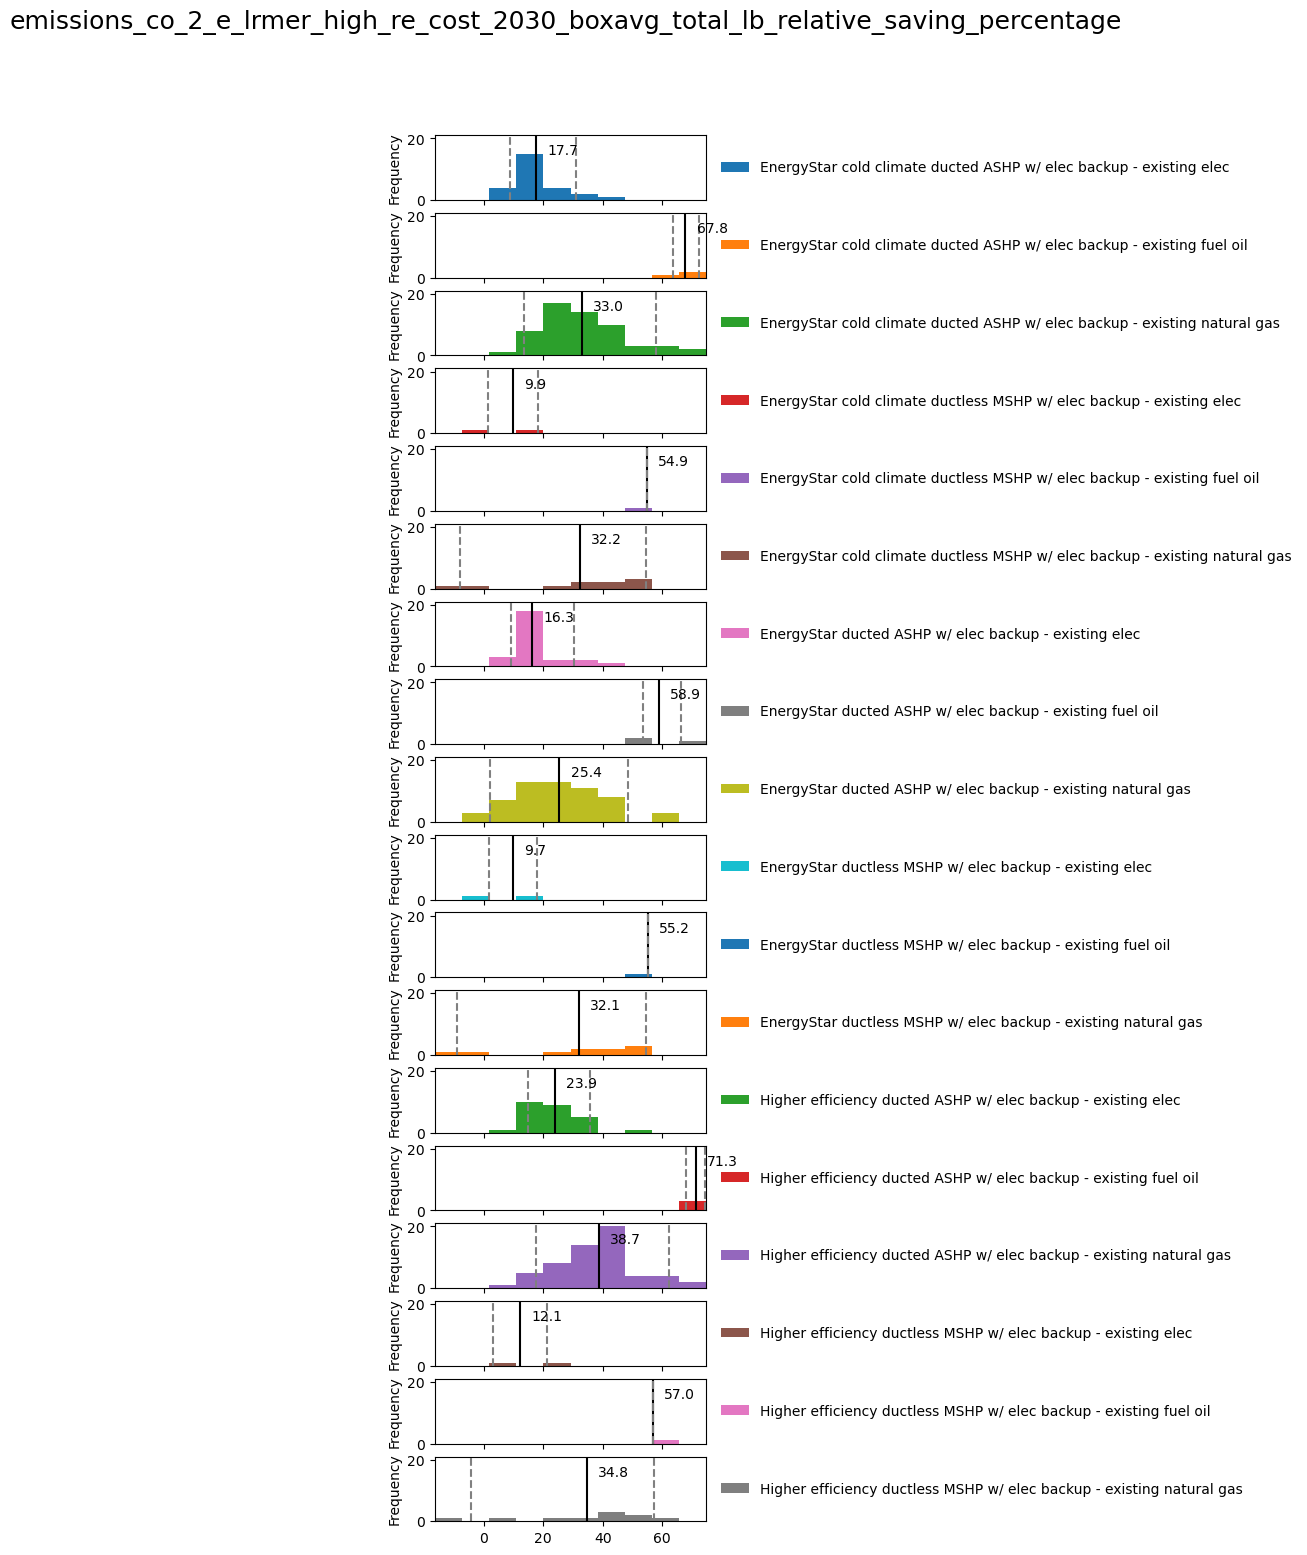

In [97]:
metric = "report_simulation_output.emissions_co_2_e_lrmer_high_re_cost_2030_boxavg_total_lb"
output_type = "relative_saving_percentage" # negative saving means net increase

hc = ["upgrade"] # "lmi", "tenure"
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_relative_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

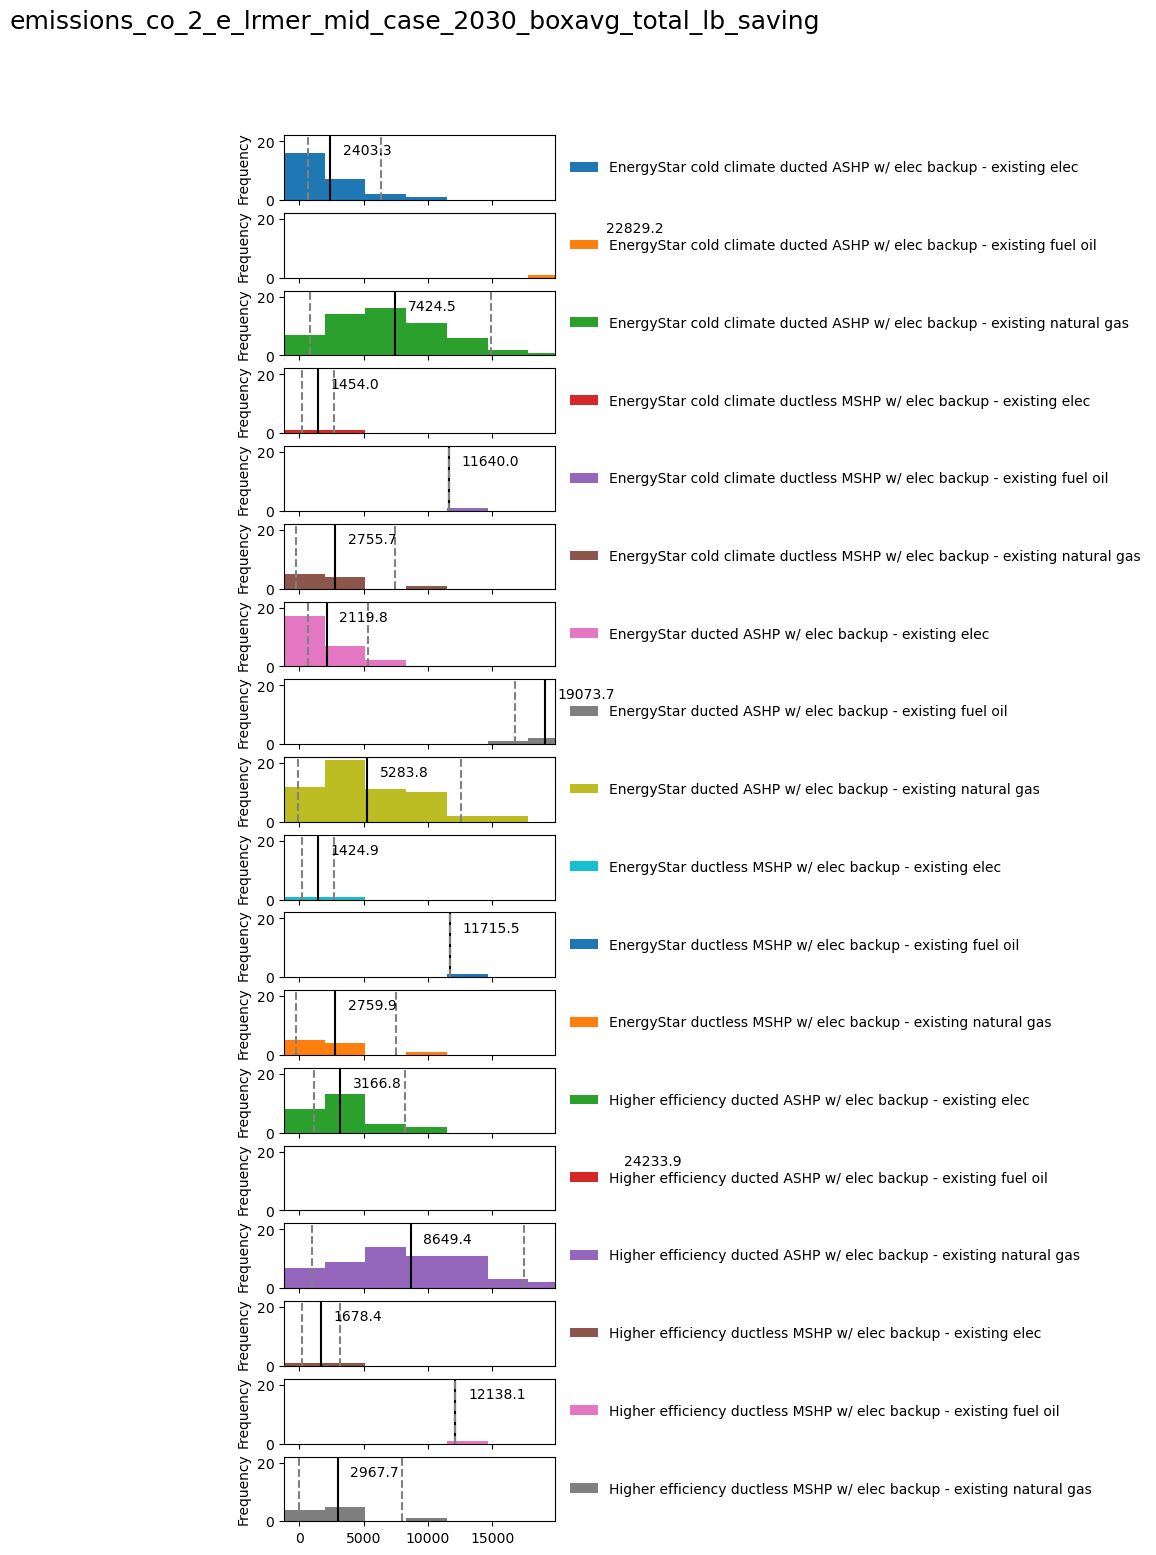

In [98]:
metric = "report_simulation_output.emissions_co_2_e_lrmer_mid_case_2030_boxavg_total_lb"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"] # "lmi", "tenure"
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

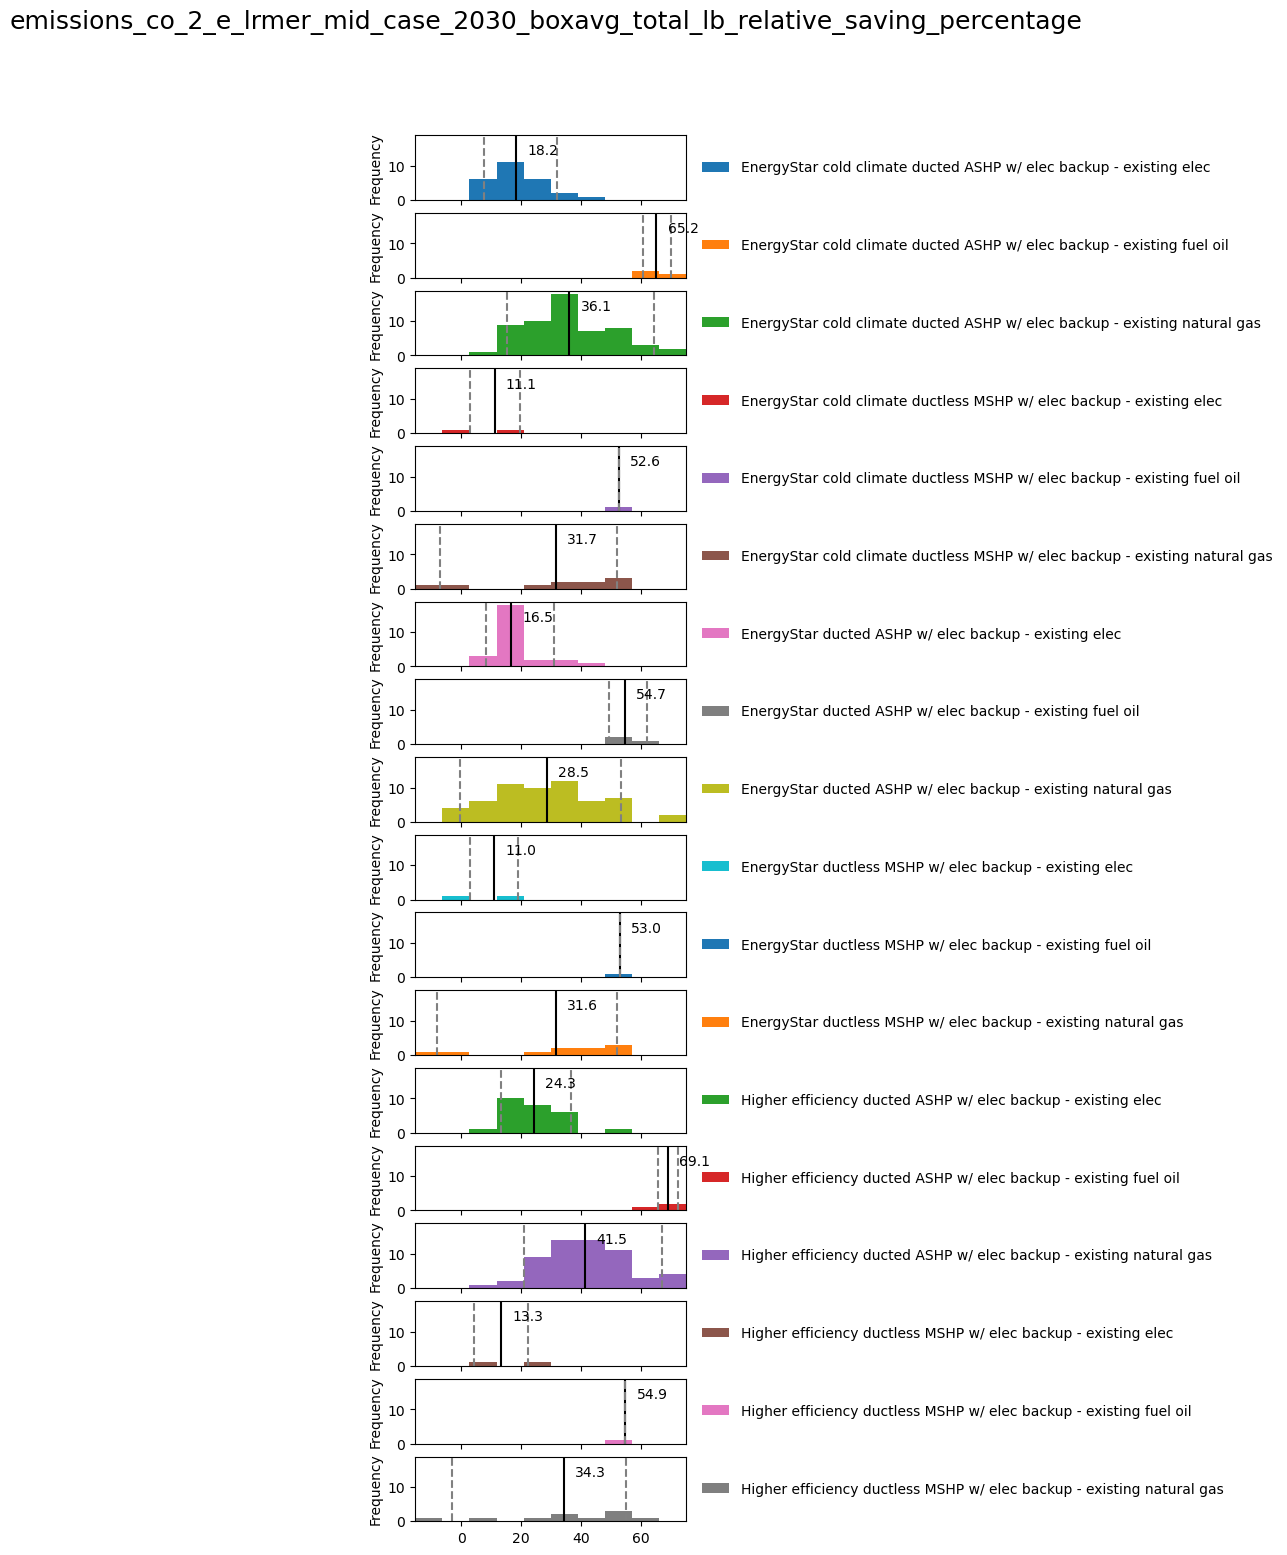

In [99]:
metric = "report_simulation_output.emissions_co_2_e_lrmer_mid_case_2030_boxavg_total_lb"
output_type = "relative_saving_percentage" # negative saving means net increase

hc = ["upgrade"] # "lmi", "tenure"
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_relative_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

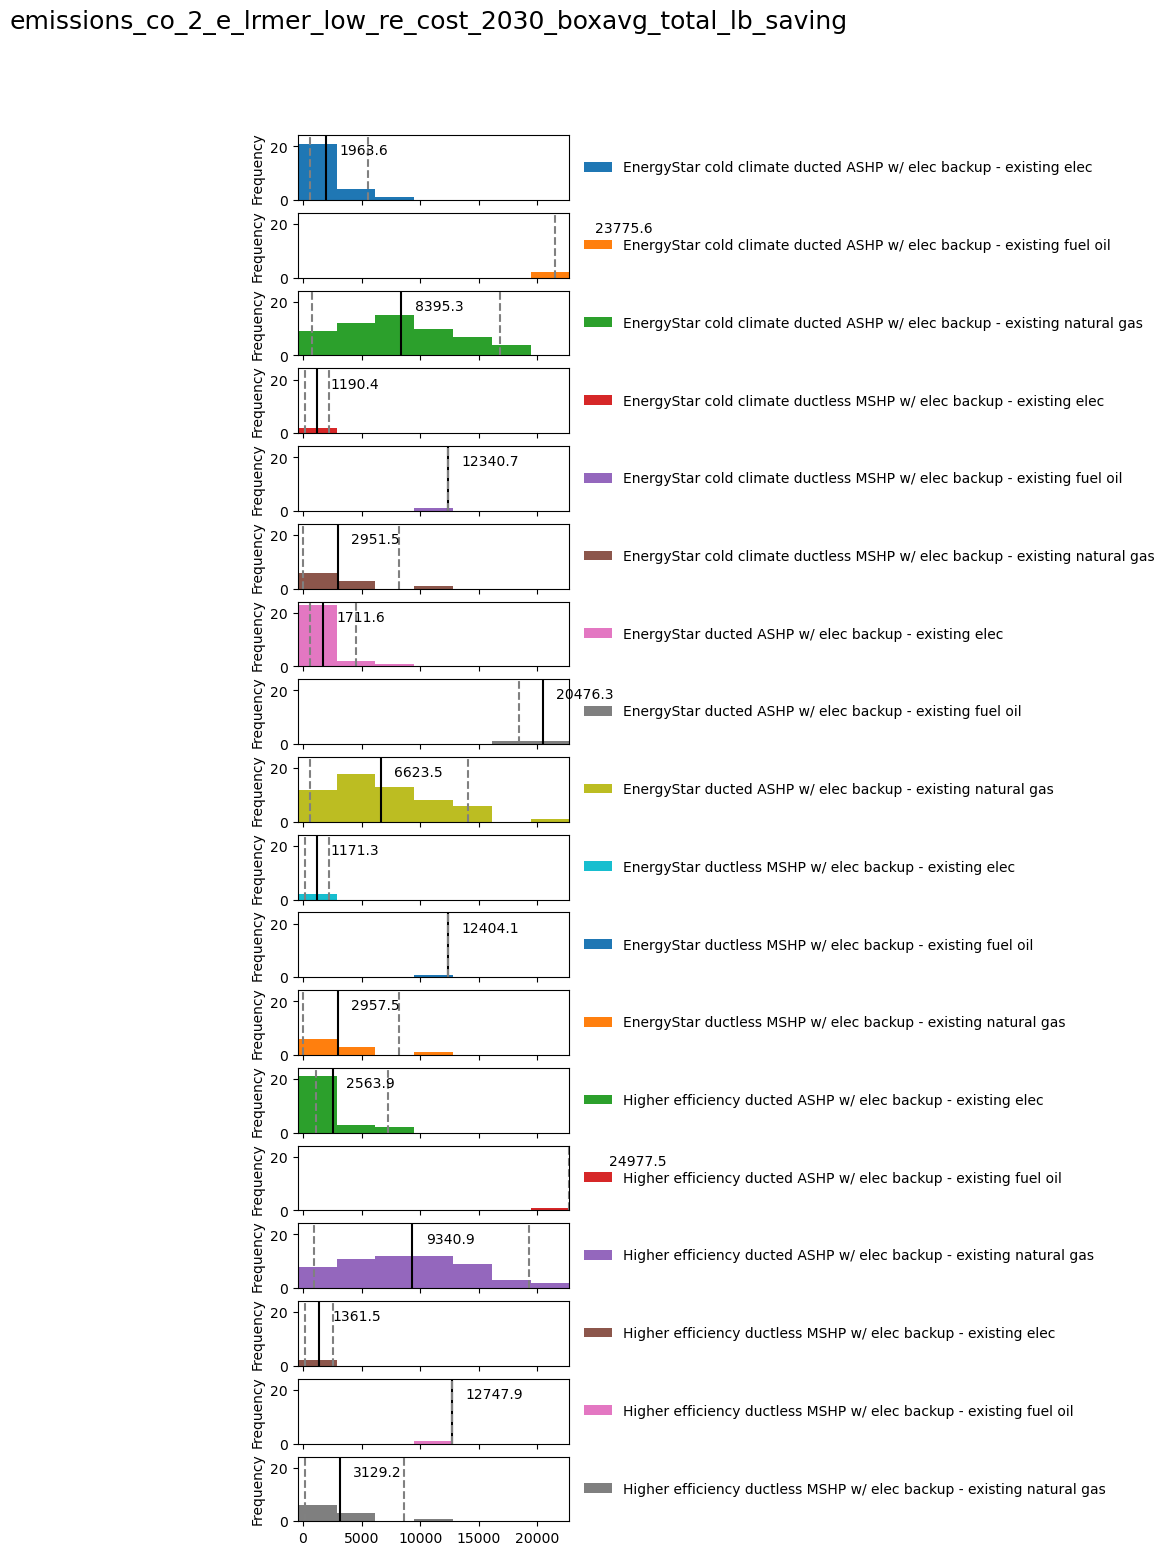

In [100]:
metric = "report_simulation_output.emissions_co_2_e_lrmer_low_re_cost_2030_boxavg_total_lb"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"] # "lmi", "tenure"
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

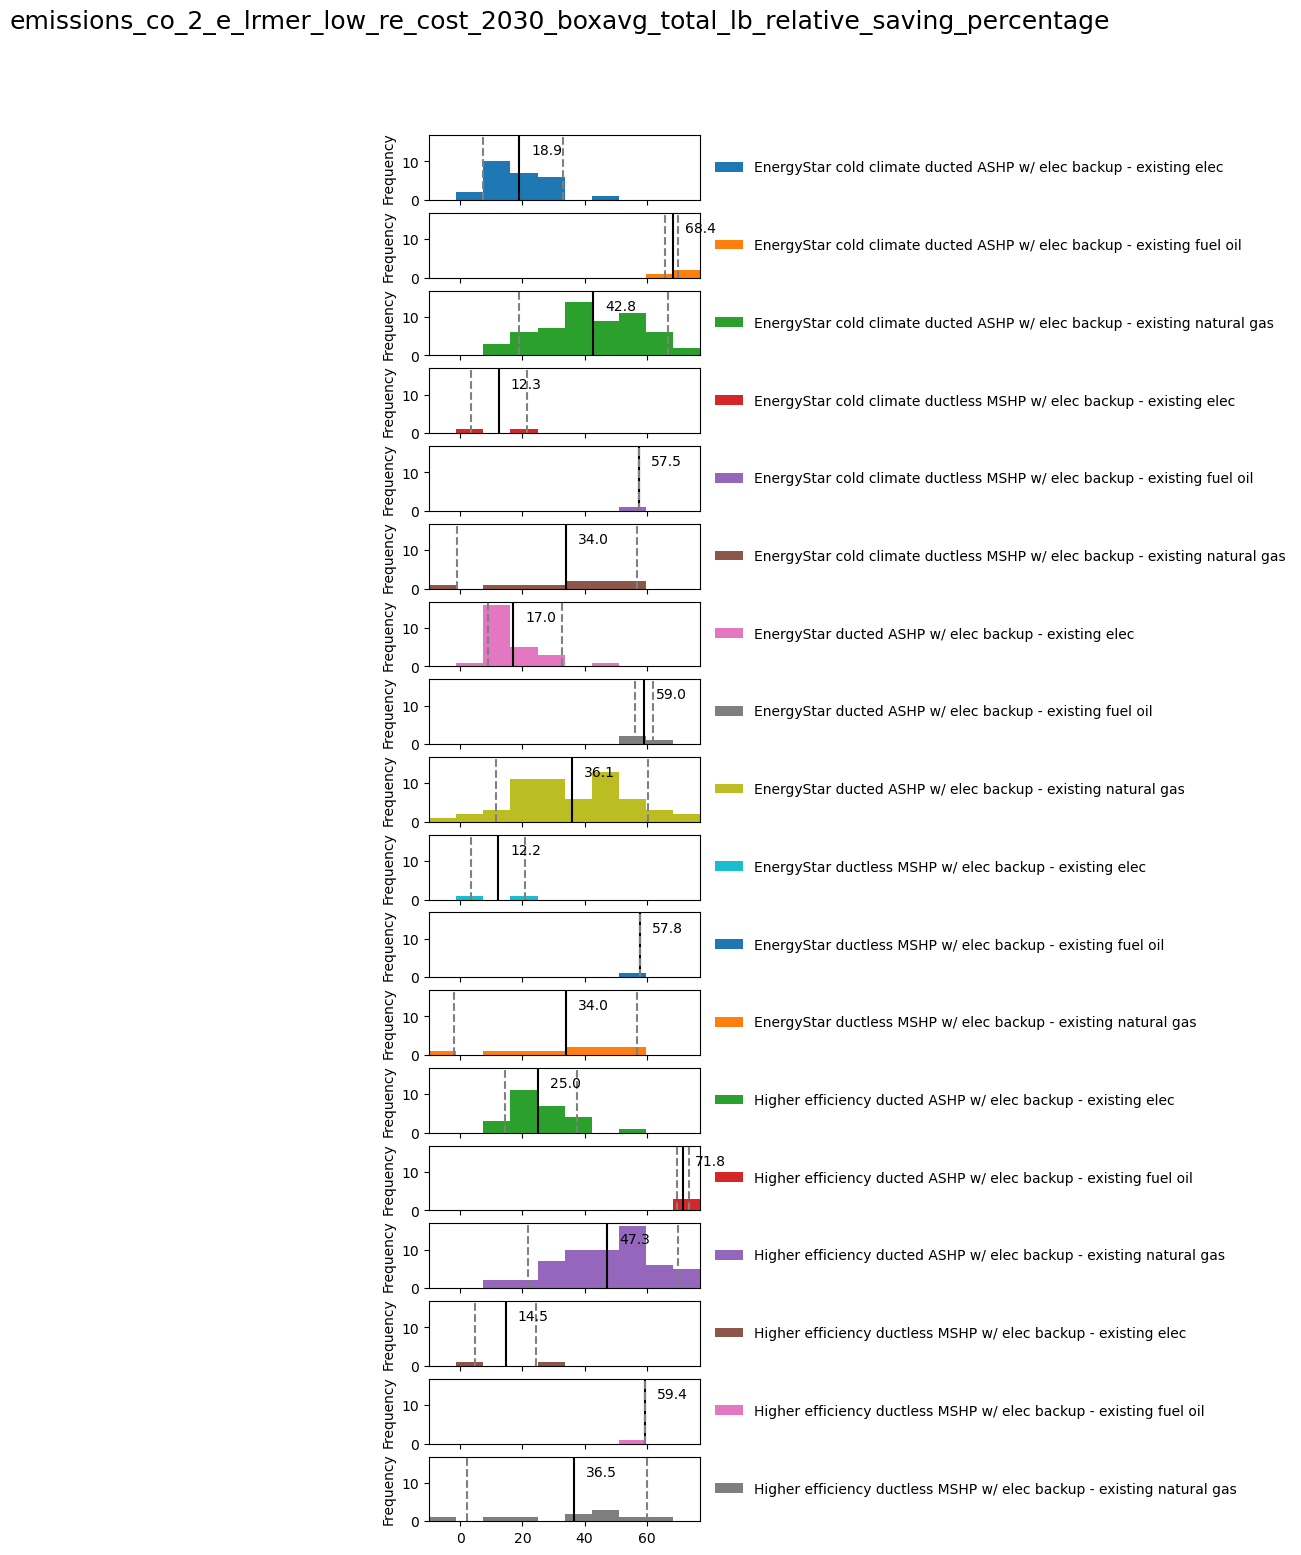

In [101]:
metric = "report_simulation_output.emissions_co_2_e_lrmer_low_re_cost_2030_boxavg_total_lb"
output_type = "relative_saving_percentage" # negative saving means net increase

hc = ["upgrade"] # "lmi", "tenure"
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_relative_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

#### 5. End use
Check end use with changes

In [76]:
metric_list = ['report_simulation_output.end_use_coal_clothes_dryer_m_btu',
 'report_simulation_output.end_use_coal_fireplace_m_btu',
 'report_simulation_output.end_use_coal_generator_m_btu',
 'report_simulation_output.end_use_coal_grill_m_btu',
 'report_simulation_output.end_use_coal_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_coal_heating_m_btu',
 'report_simulation_output.end_use_coal_hot_water_m_btu',
 'report_simulation_output.end_use_coal_lighting_m_btu',
 'report_simulation_output.end_use_coal_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_coal_range_oven_m_btu',
 'report_simulation_output.end_use_electricity_battery_m_btu',
 'report_simulation_output.end_use_electricity_ceiling_fan_m_btu',
 'report_simulation_output.end_use_electricity_clothes_dryer_m_btu',
 'report_simulation_output.end_use_electricity_clothes_washer_m_btu',
 'report_simulation_output.end_use_electricity_cooling_fans_pumps_m_btu',
 'report_simulation_output.end_use_electricity_cooling_m_btu',
 'report_simulation_output.end_use_electricity_dehumidifier_m_btu',
 'report_simulation_output.end_use_electricity_dishwasher_m_btu',
 'report_simulation_output.end_use_electricity_electric_vehicle_charging_m_btu',
 'report_simulation_output.end_use_electricity_freezer_m_btu',
 'report_simulation_output.end_use_electricity_generator_m_btu',
 'report_simulation_output.end_use_electricity_heating_fans_pumps_m_btu',
 'report_simulation_output.end_use_electricity_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_electricity_heating_m_btu',
 'report_simulation_output.end_use_electricity_hot_tub_heater_m_btu',
 'report_simulation_output.end_use_electricity_hot_tub_pump_m_btu',
 'report_simulation_output.end_use_electricity_hot_water_m_btu',
 'report_simulation_output.end_use_electricity_hot_water_recirc_pump_m_btu',
 'report_simulation_output.end_use_electricity_hot_water_solar_thermal_pump_m_btu',
 'report_simulation_output.end_use_electricity_lighting_exterior_m_btu',
 'report_simulation_output.end_use_electricity_lighting_garage_m_btu',
 'report_simulation_output.end_use_electricity_lighting_interior_m_btu',
 'report_simulation_output.end_use_electricity_mech_vent_m_btu',
 'report_simulation_output.end_use_electricity_mech_vent_precooling_m_btu',
 'report_simulation_output.end_use_electricity_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_electricity_plug_loads_m_btu',
 'report_simulation_output.end_use_electricity_pool_heater_m_btu',
 'report_simulation_output.end_use_electricity_pool_pump_m_btu',
 'report_simulation_output.end_use_electricity_pv_m_btu',
 'report_simulation_output.end_use_electricity_range_oven_m_btu',
 'report_simulation_output.end_use_electricity_refrigerator_m_btu',
 'report_simulation_output.end_use_electricity_television_m_btu',
 'report_simulation_output.end_use_electricity_well_pump_m_btu',
 'report_simulation_output.end_use_electricity_whole_house_fan_m_btu',
 'report_simulation_output.end_use_fuel_oil_clothes_dryer_m_btu',
 'report_simulation_output.end_use_fuel_oil_fireplace_m_btu',
 'report_simulation_output.end_use_fuel_oil_generator_m_btu',
 'report_simulation_output.end_use_fuel_oil_grill_m_btu',
 'report_simulation_output.end_use_fuel_oil_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_fuel_oil_heating_m_btu',
 'report_simulation_output.end_use_fuel_oil_hot_water_m_btu',
 'report_simulation_output.end_use_fuel_oil_lighting_m_btu',
 'report_simulation_output.end_use_fuel_oil_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_fuel_oil_range_oven_m_btu',
 'report_simulation_output.end_use_natural_gas_clothes_dryer_m_btu',
 'report_simulation_output.end_use_natural_gas_fireplace_m_btu',
 'report_simulation_output.end_use_natural_gas_generator_m_btu',
 'report_simulation_output.end_use_natural_gas_grill_m_btu',
 'report_simulation_output.end_use_natural_gas_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_natural_gas_heating_m_btu',
 'report_simulation_output.end_use_natural_gas_hot_tub_heater_m_btu',
 'report_simulation_output.end_use_natural_gas_hot_water_m_btu',
 'report_simulation_output.end_use_natural_gas_lighting_m_btu',
 'report_simulation_output.end_use_natural_gas_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_natural_gas_pool_heater_m_btu',
 'report_simulation_output.end_use_natural_gas_range_oven_m_btu',
 'report_simulation_output.end_use_propane_clothes_dryer_m_btu',
 'report_simulation_output.end_use_propane_fireplace_m_btu',
 'report_simulation_output.end_use_propane_generator_m_btu',
 'report_simulation_output.end_use_propane_grill_m_btu',
 'report_simulation_output.end_use_propane_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_propane_heating_m_btu',
 'report_simulation_output.end_use_propane_hot_water_m_btu',
 'report_simulation_output.end_use_propane_lighting_m_btu',
 'report_simulation_output.end_use_propane_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_propane_range_oven_m_btu',
 'report_simulation_output.end_use_wood_cord_clothes_dryer_m_btu',
 'report_simulation_output.end_use_wood_cord_fireplace_m_btu',
 'report_simulation_output.end_use_wood_cord_generator_m_btu',
 'report_simulation_output.end_use_wood_cord_grill_m_btu',
 'report_simulation_output.end_use_wood_cord_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_wood_cord_heating_m_btu',
 'report_simulation_output.end_use_wood_cord_hot_water_m_btu',
 'report_simulation_output.end_use_wood_cord_lighting_m_btu',
 'report_simulation_output.end_use_wood_cord_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_wood_cord_range_oven_m_btu',
 'report_simulation_output.end_use_wood_pellets_clothes_dryer_m_btu',
 'report_simulation_output.end_use_wood_pellets_fireplace_m_btu',
 'report_simulation_output.end_use_wood_pellets_generator_m_btu',
 'report_simulation_output.end_use_wood_pellets_grill_m_btu',
 'report_simulation_output.end_use_wood_pellets_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_wood_pellets_heating_m_btu',
 'report_simulation_output.end_use_wood_pellets_hot_water_m_btu',
 'report_simulation_output.end_use_wood_pellets_lighting_m_btu',
 'report_simulation_output.end_use_wood_pellets_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_wood_pellets_range_oven_m_btu']
output_type = "saving" # negative saving means net increase

dfs = qaqc_helper.load_process.get_upgrade_saving_list_dataframe(dfb, DFU, metric_list, output_type=output_type)
metric_list_new = [x + '_saving' for x in metric_list]
dfs = dfs[metric_list_new]    
temp = dfs.any()
temp = temp.to_frame()
temp.columns =["end_use_with_changes"]
end_use_with_changes = temp.loc[temp["end_use_with_changes"] == True]
end_use_with_changes

,end_use_with_changes
report_simulation_output.end_use_electricity_clothes_dryer_m_btu_saving,True
report_simulation_output.end_use_electricity_cooling_fans_pumps_m_btu_saving,True
report_simulation_output.end_use_electricity_cooling_m_btu_saving,True
report_simulation_output.end_use_electricity_heating_fans_pumps_m_btu_saving,True
report_simulation_output.end_use_electricity_heating_heat_pump_backup_m_btu_saving,True
report_simulation_output.end_use_electricity_heating_m_btu_saving,True
report_simulation_output.end_use_electricity_hot_water_m_btu_saving,True
report_simulation_output.end_use_fuel_oil_heating_m_btu_saving,True
report_simulation_output.end_use_fuel_oil_hot_water_m_btu_saving,True
report_simulation_output.end_use_natural_gas_clothes_dryer_m_btu_saving,True


If there are any unexpected end use with change, then see histogram for end use with changes below

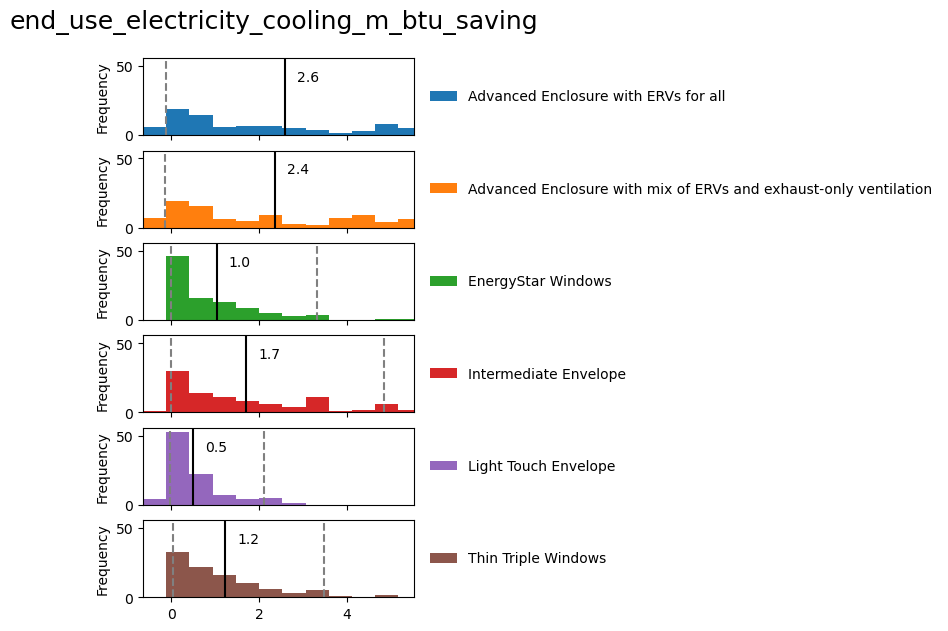

In [48]:
metric = "report_simulation_output.end_use_electricity_cooling_m_btu"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"]
nbins = 20

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

#### 6. Fuel and end use savings at individual model level

In [30]:
fuel_list = ['coal', 'electricity','fuel_oil','natural_gas','propane','wood_cord','wood_pellets']
fuel_end_use_with_changes = []
for fuel in fuel_list:
    if dfb[f'report_simulation_output.fuel_use_{fuel}_total_m_btu'].any() == True:
        fuel_end_use_with_changes.append(f'report_simulation_output.fuel_use_{fuel}_total_m_btu')
temp = list(end_use_with_changes.index)
temp = [s.strip('_saving') for s in temp]
fuel_end_use_with_changes.extend(temp)

results = pd.DataFrame()
metric = 'report_simulation_output.fuel_use_electricity_total_m_btu'
output_type = "saving" # negative saving means net increase
temp = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
results['building_id']=temp['building_id']
results['upgrade']=temp['upgrade']

for end_use in fuel_end_use_with_changes:
    metric = end_use
    output_type = "saving" # negative saving means net increase
    temp = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
    results_temp = pd.DataFrame()
    results_temp[f'{end_use}_saving'] = temp[f'{end_use}_saving']
    frames = [results, results_temp]
    results = pd.concat(frames, axis=1)
    
upgrade_list = list(results['upgrade'].unique())
for upgrade in upgrade_list:
    results_upgrade = results.loc[results['upgrade'] == upgrade]
    results_upgrade = results_upgrade.loc[:, (results_upgrade != 0).any(axis=0)]
    results_upgrade.to_csv(f'fuel_end_use_with_changes_{upgrade}.csv')